In [1]:
import sys
sys.path.append("../")
%run ../nn_option_pricer/_key_imports.py
from nn_option_pricer.sabr import *
from nn_option_pricer.bs import *

In [212]:
from numpy.random import default_rng
rng = default_rng(42)
N_BROWNIANS = 10 ** 4
MAX_N_TIMES = 30
Z1 = rng.standard_normal((N_BROWNIANS, MAX_N_TIMES))
Z2 = rng.standard_normal((N_BROWNIANS, MAX_N_TIMES))
N_SAMPLES = 10 ** 4

In [214]:
import jax
# grad_vt = jax.numpy.vectorize(jax.grad(gbm_step, argnums = (0, 1, 2)))(V0, 0.01, vol_of_vol, Z1[:, 0])
# grad_vt = [np.array(x) for x in grad_vt]

# grad_ft = jax.numpy.vectorize(jax.grad(cev_step, argnums = (0, 1, 2, 3, 5)))(F0, Vt, 1.0, 0.01, Z1[:, 0], rho, Z2[:, 0])
# grad_ft = [np.array(x) for x in grad_ft]

def sabr_call(F0, V0, dt, vol_of_vol, beta, rho, K, Z1, Z2, N_TIMES:np.int32):
    if N_TIMES >= 1:
        Vt = gbm_step(F = jnp.log(V0), dt = dt, sigma = vol_of_vol, Z = Z1[:, 0])
        Ft = cev_step(F0, jnp.exp(Vt), beta = beta, dt = dt, Z1 = Z1[:, 0], rho = rho, Z2 = Z2[:, 0])
    for i in range(int(N_TIMES) - 1):
        Vt = gbm_step(F = Vt, dt = dt, sigma = vol_of_vol, Z = Z1[:, i])
        Ft = cev_step(Ft, jnp.exp(Vt), beta = beta, dt = dt, Z1 = Z1[:, i], rho = rho, Z2 = Z2[:, i])
    return jnp.mean(jnp.maximum(Ft - K, 0.0))

params = {"vol_of_vol": (1e-3, 0.2),
           "beta": (1.0, 1.0),
           "rho": (-0.97, 0),
           "V0":(0.1, 0.3),
            "F0": (1.0, 1.0),
           "K": (1e-2, 3.0),
           "N_TIMES": (1, 30)}
N_SAMPLES = 10000
params_df = pd.DataFrame({x: rng.uniform(params[x][0], params[x][1], N_SAMPLES) for x in params})
params_df['N_TIMES'] = rng.integers(params["N_TIMES"][0], params["N_TIMES"][1], N_SAMPLES)

time.time()
call_func = lambda x: float(sabr_call(x["F0"], x["V0"], 1e-1, x["vol_of_vol"], x["beta"], x["rho"], x["K"], Z1, Z2, x["N_TIMES"]))
params_df['MC_call'] = params_df.progress_apply(call_func, axis = 1) 
call_func = lambda x: [np.float32(x) for x in jax.grad(sabr_call, argnums=(0, 1, 2, 3, 4, 5, 6))(x["F0"], x["V0"], 1e-1, x["vol_of_vol"], x["beta"], x["rho"], x["K"], Z1, Z2, x["N_TIMES"])]
grads = params_df.progress_apply(call_func, axis = 1) 
end = time.time()
#     temp_grad_ft = jax.numpy.vectorize(jax.grad(cev_step, argnums = (0, 1, 2, 3, 5)))(F0, Vt, 1.0, 0.01, Z1[:, 0], rho, Z2[:, 0])
#     for i,x in enumerate (temp_grad_vt):
#         grad_vt[i] *= np.array(x)
#     for i,x in enumerate (temp_grad_ft):
#         grad_ft[i] *= np.array(x)

# K = 1.0

# dCdFT, dCdK = jax.numpy.vectorize(jax.grad(call_payoff, argnums=(0, 1)))(Ft, K)

# ["F", "v", ""]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [217]:
params_df

,vol_of_vol,beta,rho,V0,F0,K,N_TIMES,MC_call
0,0.193943,1.0,-0.243881,0.188226,1.0,1.243985,11,0.150161
1,0.088247,1.0,-0.380572,0.270961,1.0,1.569022,15,0.083392
2,0.053511,1.0,-0.390777,0.208119,1.0,0.060690,7,0.970705
3,0.196238,1.0,-0.374875,0.208186,1.0,0.911074,13,0.392865
4,0.147403,1.0,-0.028637,0.251006,1.0,0.938751,18,0.478729
...,...,...,...,...,...,...,...,...
9995,0.148796,1.0,-0.846421,0.233389,1.0,2.662207,2,0.000000
9996,0.098177,1.0,-0.622576,0.256869,1.0,0.740647,7,0.324246
9997,0.080047,1.0,-0.293667,0.120683,1.0,0.616489,27,0.479546
9998,0.114068,1.0,-0.543539,0.285653,1.0,1.562416,16,0.136774


In [216]:
params_df.to_csv("sabr_train.csv")

$\frac{\partial}{\partial T} \frac{\partial T}{\partial \Delta t} = N\frac{\partial}{\partial T}$

In [175]:
def sabr_expansion(F, K, vol, beta, rho, vol_of_vol, ttm):
    """
    rho: correlation between brownian motions
    vol_of_vol: vol of vol
    vol: spot vol
    ttm: time to maturity
    """
    import jax.numpy as np

    F_K = (F * K) ** (1.0 - beta)
    mon = np.log(F / K)
    z = (vol_of_vol / vol) * (F_K**0.5) * mon
    x = np.log((np.sqrt(1.0 - 2.0 * rho * z + (z**2.0)) + z - rho) / (1.0 - rho))
    num = 1.0 + ttm * (
        ((1.0 - beta) ** 2.0) * ((vol**2) / F_K) / 24.0
        + 0.25 * rho * beta * vol_of_vol * vol / (F_K * 0.5)
        + (2.0 - 3.0 * (rho**2)) * ((vol_of_vol) ** 2) / 24.0
    )
    denom = (F_K**0.5) * (
        1.0 + ((1.0 - beta) ** 2.0) / 24.0 * mon**2.0 + ((1.0 - beta) ** 4) / 1920.0 * mon**4.0
    )
    if F == K:
        return (vol * num / denom) + (z / x) * vol * num / denom
    return (z / x) * vol * num / denom

In [211]:
call_func = lambda x: [np.float32(x) for x in jax.grad(sabr_expansion, argnums=(0, 1, 2, 3, 4, 5, 6))(x["F0"], x["K"], x["V0"], x["beta"], x["rho"], x["vol_of_vol"], 1e-1 * x["N_TIMES"])]
params_df.progress_apply(call_func, axis = 1) 

  0%|          | 0/100 [00:00<?, ?it/s]

0     [-0.0051043006, 0.0031911212, 0.8986728, 0.021...
1     [0.027790936, -0.07904983, 0.9580048, -0.09421...
2     [0.018013047, -0.015608372, 0.9892327, 0.01615...
3     [0.0016609934, -0.0006965018, 0.9986461, 0.123...
4     [0.0045110392, -0.004735645, 0.99850196, -0.00...
                            ...                        
95    [0.015410162, -0.008284057, 0.9735744, 0.07022...
96    [0.012549919, -0.009785331, 0.98879266, 0.0289...
97    [0.001900295, -0.00074512453, 0.96951014, 0.07...
98    [-0.0014140508, 0.0008968654, 0.9934713, 0.065...
99    [-0.016236877, 0.0056759873, 0.9240758, 0.0900...
Length: 100, dtype: object

In [179]:
df["sabr_expansion_vol"]  = np.array(sabr_expansion(
    F=df['F0'].values,
    K=df["K"].values,
    vol=df['V0'].values,
    vol_of_vol=df["vol_of_vol"].values,
    beta=df["beta"].values,
    rho=df["rho"].values,
    ttm=1e-3 * df["N_TIMES"].values,
)).copy()

In [136]:
start = time.time()
df["sabr_expansion_vol"]  = np.array(sabr_expansion(
    F=df['F0'].values,
    K=df["K"].values,
    vol=df['V0'].values,
    vol_of_vol=df["vol_of_vol"].values,
    beta=df["beta"].values,
    rho=df["rho"].values,
    ttm=1e-3 * df["N_TIMES"].values,
)).copy()
df["sabr_expansion_call"] = np.array(df["K"].values * jax_bs_call(
    SK=-np.log(df["K"].values),
    sigma_tau=df["sabr_expansion_vols"].values * np.sqrt(1e-3 * df["N_TIMES"].values),
)).copy()

df["sabr_expansion_digital"] = np.array(jax_bs_digital(
    SK=-np.log(df["K"].values),
    sigma_tau=df["sabr_expansion_vols"].values * np.sqrt(1e-3 * df["N_TIMES"].values),
)).copy()


end = time.time()


<AxesSubplot:xlabel='K', ylabel='sabr_expansion_call'>

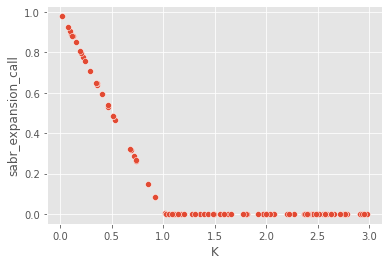

In [133]:
sns.scatterplot(df['K'], df["sabr_expansion_call"])

In [95]:
feat_names = ["F0", "V0", "T", "vol_of_vol", "beta", "rho", "K"]

In [96]:
grads_df = grads.apply(pd.Series)
grads_df.columns = [f"MC_call_d/d{x}" for x in feat_names]

In [32]:
sabr_call(**params_df.iloc[0].to_dict(), dt = 1e-2, Z1 = Z1, Z2 = Z2)

DeviceArray(1.9686687e+10, dtype=float32)

In [129]:
np.array(jax.numpy.mean(dCdFT.reshape(-1) * np.vstack(grad_ft), axis= 0))

array([1.0964485e-01, 1.2520440e-01, 3.9947690e+26, ..., 1.8609553e+10,
       2.4329942e+20, 0.0000000e+00], dtype=float32)

In [92]:
np.vstack(grad_ft).T

array([[5.4803699e-01, 0.0000000e+00, 0.0000000e+00, 1.8729456e-04,
        0.0000000e+00],
       [6.2602061e-01, 0.0000000e+00, 0.0000000e+00, 1.3507420e-06,
        0.0000000e+00],
       [1.7352235e+02, 3.4595807e-32, 0.0000000e+00, 1.9973844e+27,
        1.4012985e-45],
       ...,
       [5.4214746e-01, 1.5870535e-30, 0.0000000e+00, 9.3047767e+10,
        2.4100436e-38],
       [1.8762007e+01, 1.4425458e-35, 0.0000000e+00, 1.2164971e+21,
        1.6083309e-20],
       [1.7131023e+02, 1.3596183e-26, 0.0000000e+00, 4.1656849e+28,
        3.1139939e-36]], dtype=float32)

In [73]:
grad_vt

<generator object <genexpr> at 0x134d00d60>

In [56]:
jax.numpy.vectorize(jax.grad(gbm_step, argnums = (0, 1, 2)))(V0, 0.01, vol_of_vol, Z1[:, 0])

(DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 DeviceArray([-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],            dtype=float32, weak_type=True),
 DeviceArray([-0.34838662, -0.04697683,  0.74485254, ...,  0.18157001,
              -1.6643364 , -0.96437496], dtype=float32, weak_type=True))

In [64]:
grad_ft

(DeviceArray([1.0015459, 0.999686 , 1.0025632, ..., 1.0368187, 0.9843472,
              0.986478 ], dtype=float32, weak_type=True),
 DeviceArray([-0.01892465, -0.01305826,  0.10395478, ...,  0.11715706,
              -0.08151224, -0.15547812], dtype=float32),
 DeviceArray([ 0., -0.,  0., ...,  0., -0., -0.], dtype=float32, weak_type=True),
 DeviceArray([ 0.07729489, -0.01569996,  0.12816289, ...,  1.8409377 ,
              -0.7826401 , -0.67610013], dtype=float32, weak_type=True),
 DeviceArray([-0.00336711, -0.00034584,  0.00070734, ...,  0.05580914,
               0.04131442, -0.0066998 ], dtype=float32))

In [20]:
"""
Set Parameters
"""
SEED = 42
rng = default_rng(SEED)

"""
Fix Terminal Maturity
"""

def make_sabr_dataset(N_SAMPLES = 100, N_TIMES = 100, T = 1, 
                      params = {"vol_of_vol": (1e-3, 1.0),
                               "beta": (1, 1),
                               "rho": (-0.97, 0),
                               "v0":(0.1, 0.3)},
                                F0 = 1.0,
                     SEED = 42,
                      N_STRIKES = 16,
                      k_range = (-4.0 , 3.0),
                     N_BROWNIANS = 2**15):

    dt = T / (N_TIMES)
    ts = np.linspace(dt, T, N_TIMES).reshape((1, -1))


    """
    Define Paramters
    """
    from numpy.random import default_rng
    rng = default_rng(SEED)
    params_df = pd.DataFrame({x: rng.uniform(params[x][0], params[x][1], N_SAMPLES) for x in params})
    
    vol_of_vols = params_df['vol_of_vol'].values.reshape((-1, 1))
    betas = params_df['beta'].values
    rhos = params_df['rho'].values
    V0s = params_df['v0'].values.reshape((-1, 1))
    Z1 = rng.standard_normal((N_BROWNIANS, N_TIMES))
    Z2 = rng.standard_normal((N_BROWNIANS, N_TIMES))
    
    Ks = np.exp(np.linspace(k_range[0], k_range[1], N_STRIKES)).reshape((1, 1, -1))

    """
    Generate dataset via MC
    Combine to create dataset
    """
    all_calls = []
    all_digitals = []

    Xs = []
    calls = []
    digitals = []
    feat_names = ["K", "ttm", "v0", "vol_of_vol", "beta", "rho"]
    f_to_i = lambda x: feat_names.index(x)

    gen_time = time.time()
    for i in tqdm(range(N_SAMPLES)):
        # exact simulation of the volatility process
        vol_of_vol, beta, rho, V0 = vol_of_vols[i], betas[i], rhos[i], V0s[i]
        Vt = np.hstack(
            [
                V0
                * np.exp(
                    -(0.5 * vol_of_vol**2) * ts
                    + vol_of_vol * np.sqrt(dt) * np.cumsum(Z2, axis=1)
                )
            ]
        )
        Ft = np.zeros((N_BROWNIANS, N_TIMES + 1))
        Ft[:, 0] = F0  # fix F0 = 1.0

        deltas = np.zeros((N_BROWNIANS, N_TIMES + 1))

        for i in range(N_TIMES):
            Ft[:, i + 1] = cev_step(Ft[:, i], Vt[:, i], beta, dt, Z1[:, i], rho, Z2[:, i])

        call_surface = np.mean(
            np.maximum(Ft[:, 1:].reshape((N_BROWNIANS, N_TIMES, 1)) - Ks, 0), axis=0
        ).T
        digital_surface = np.mean(
            (Ft[:, 1:].reshape((N_BROWNIANS, N_TIMES, 1)) > Ks), axis=0
        ).T

        temp = np.zeros((N_TIMES * N_STRIKES, 6))  # F, K, ttm, alpha, beta, rho, vol_of_vol
        temp[:, [0, 1]] = np.vstack(
            [
                np.repeat(Ks, N_TIMES),  # strikes
                np.repeat(ts, N_STRIKES).reshape((N_STRIKES, -1)).T.reshape(-1),
            ]
        ).T
        temp[:, f_to_i("v0")] = V0
        temp[:, f_to_i("beta")] = beta
        temp[:, f_to_i("vol_of_vol")] = vol_of_vol
        temp[:, f_to_i("rho")] = rho
        Xs += [temp]

        calls += [call_surface.reshape(-1)]
        digitals += [digital_surface.reshape(-1)]
        

        Xs = np.concatenate(Xs)
        X_df = pd.DataFrame(Xs, columns=feat_names)
        X_df["call_MC"] = np.concatenate(calls)
        X_df["digital_MC"] = np.concatenate(digitals)
        end_time = time.time()

        # print(Xs.shape, ys.shape)
        assert np.concatenate(calls).shape[0] == Xs.shape[0]
        assert np.concatenate(digitals).shape[0] == Xs.shape[0]

        """
        Writeout to csv
        """
        return X_df


X_df_train = make_sabr_dataset(N_SAMPLES = 100, N_TIMES = 100, T = 1, 
                  params = {"vol_of_vol": (1e-3, 1.0),
                           "beta": (1, 1),
                           "rho": (-0.97, 0),
                           "v0":(0.1, 0.3)},
                            F0 = 1.0,
                 SEED = 42,
                  N_STRIKES = 16,
                  k_range = (-4.0 , 3.0),
                 N_BROWNIANS = 2**15)
print(gen_time, X_df_train.shape)
# """
# Compute SABR approximation
# """
# scaling = 1
# X_df["sabr_expansion_vols"] = sabr_expansion(
#     F=1.0,
#     K=X_df["K"].values,
#     vol=X_df["v0"].values * scaling ** (X_df["beta"] - 1).values,
#     vol_of_vol=X_df["vol_of_vol"].values,
#     beta=X_df["beta"].values,
#     rho=X_df["rho"].values,
#     ttm=X_df["ttm"].values,
# )

# X_df["sabr_expansion_BS_call"] = X_df["K"].values * jax_bs_call(
#     SK=-np.log(X_df["K"].values),
#     sigma_tau=X_df["sabr_expansion_vols"].values * np.sqrt(X_df["ttm"].values),
# )

# X_df["sabr_expansion_BS_digital"] = jax_bs_digital(
#     SK=-np.log(X_df["K"].values),
#     sigma_tau=X_df["sabr_expansion_vols"].values * np.sqrt(X_df["ttm"].values),
# )
X_df.to_csv("datasets/X_df_train.csv", index=False)
display(X_df)

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'jax_BS_call' is not defined

In [ ]:
"""
Visualise data
"""
# Marginal Distributions of Parameter Space
fig, ax = plt.subplots(figsize=(5 * len(feat_names), 5), ncols=len(feat_names))
for i in range(len(feat_names)):
    X_df.iloc[:, i].plot(kind="hist", ax=ax[i], bins=50)
    ax[i].set_title(feat_names[i])
# Terminal Distribution of underlying
fig, ax = plt.subplots(ncols=2)
sns.scatterplot(x=X_df["K"], y=X_df["ttm"], ax=ax[1])
# sns.histplot(Ft[:, -1], ax = ax[0])
ax[0].set_title("Terminal Distribution of log S/K")
ax[0].set_xlabel("S/K")
ax[1].set_title("Sample Space")
ax[1].set_xlabel("S/K")
ax[1].set_ylabel("ttm")
# sample payoff, intrinsic val v S/K

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
intrinsic_val = np.maximum(1.0 - X_df["K"], 0)
sns.scatterplot(x=X_df["K"], y=X_df["call_MC"], hue=X_df["ttm"], ax=ax[0])
sns.scatterplot(x=X_df["K"], y=intrinsic_val, ax=ax[0])
ax[0].set_title("Sample payoffs vs Moneyness")
# sns.scatterplot(x = X_df['S/K'], y = X_df['call_true'], hue = X_df['ttm'], ax = ax[1])
# ax[1].set_title("True payoffs vs Monyness")

In [ ]:
subsample = X_df.sample(1000)
sns.scatterplot(np.log(subsample["K"]), subsample["digital_MC"], hue=subsample["ttm"])

Text(0.5, 1.0, 'SABR Expansion vs MC')

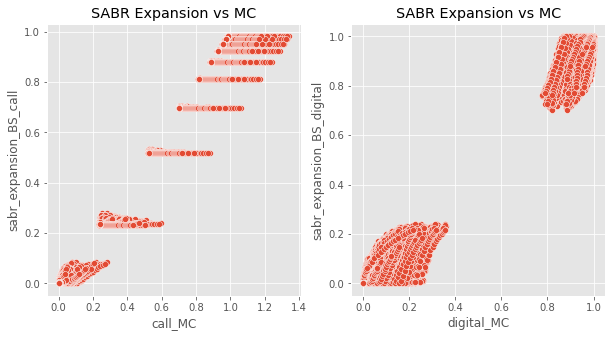

In [186]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(X_df["call_MC"], X_df["sabr_expansion_BS_call"], ax=ax[0])

sns.scatterplot(X_df["digital_MC"], X_df["sabr_expansion_BS_digital"], ax=ax[1])
ax[0].set_title("SABR Expansion vs MC")
ax[1].set_title("SABR Expansion vs MC")